<a href="https://colab.research.google.com/github/aburkov/theLMbook/blob/main/document_classifier_with_LLMs_as_labelers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Training a Document Classifier by a Taxonomy

In this tutorial, we will train a document classifier capable of classfying documents according to a given taxonomy.

Contrary to many exising tutorials that start with a labeled dataset ready for training, we will:

1. Download a corpus of unlabeled documents
2. Download a real-world taxonomy
3. Use an ensemble of language model APIs to label the documents by the taxonomy with a high accuracy
4. Build a labeled dataset for supervised learning from the documents and LLM-assigned labels
5. Use Colab and SwarmoOne to train a series of models of different sizes to see how the classifier quality depends on the model size

Let's go!

## Getting the Documents

The documents we will train our neural networks to classify will be titles and abstracts from a collection of STEM papers. First, we download from [Kaggle](https://www.kaggle.com/) a raw file with the [ArXiv](https://arxiv.org/) paper metadata for our collection of papers:

In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("Cornell-University/arxiv")

print("Path to dataset files:", path)
print("Files in dataset directory:", os.listdir(path))

Path to dataset files: /kaggle/input/arxiv
Files in dataset directory: ['arxiv-metadata-oai-snapshot.json']


Let's print two records from this dataset in their raw state:

In [ ]:
import json
from pprint import pprint
# Construct the full path to the JSON file
file_path = os.path.join(path, 'arxiv-metadata-oai-snapshot.json')

# Open the file and read the first two lines
with open(file_path, 'r') as file:
    # Read and parse the first record
    first_line = file.readline()
    first_record = json.loads(first_line)

    # Read and parse the second record
    second_line = file.readline()
    second_record = json.loads(second_line)

# Print the first two records
print("First record:")
pprint(first_record)
print("\nSecond record:")
pprint(second_record)

First record:
{'abstract': '  A fully differential calculation in perturbative quantum '
             'chromodynamics is\n'
             'presented for the production of massive photon pairs at hadron '
             'colliders. All\n'
             'next-to-leading order perturbative contributions from '
             'quark-antiquark,\n'
             'gluon-(anti)quark, and gluon-gluon subprocesses are included, as '
             'well as\n'
             'all-orders resummation of initial-state gluon radiation valid '
             'at\n'
             'next-to-next-to-leading logarithmic accuracy. The region of '
             'phase space is\n'
             'specified in which the calculation is most reliable. Good '
             'agreement is\n'
             'demonstrated with data from the Fermilab Tevatron, and '
             'predictions are made for\n'
             'more detailed tests with CDF and DO data. Predictions are shown '
             'for\n'
             'distributions of 

We see that the abstract is formatted as a concatenation of short chunks whith new line characters at the end of each chunk. Let's parse the entire dataset by reading only the ID, title, and abstract into a list. We will also "clean" the abstract by concatenating the chunks and removing the unnecessary new line characters:

In [ ]:
import json
from pprint import pprint

def clean_abstract(text):
    """Clean the abstract by preserving paragraphs and removing unnecessary newlines within paragraphs."""
    # Split into paragraphs using double newlines
    paragraphs = text.split('\n\n')
    cleaned_paragraphs = []
    for paragraph in paragraphs:
        # Replace single newlines with spaces within each paragraph
        cleaned_paragraph = ' '.join(line.strip() for line in paragraph.split('\n'))
        cleaned_paragraphs.append(cleaned_paragraph)
    # Join paragraphs back with double newlines
    return '\n\n'.join(cleaned_paragraphs)

def clean_title(text):
    """Clean the title by removing extra spaces and joining lines with spaces."""
    return ' '.join(line.strip() for line in text.split('\n'))

records = []

# Open the file and read the first two lines
with open(file_path, 'r') as file:
    for line in file:
        record = json.loads(line)
        filtered_record = {
            'id': record.get('id', ''),
            'title': clean_title(record.get('title', '')),
            'abstract': clean_abstract(record.get('abstract', ''))
        }
        records.append(filtered_record)

# Print the first two records
for i, record in enumerate(records[:2], start=1):
    print(f"Record {i}:")
    print(f"ID: {record['id']}")
    print(f"Title: {record['title']}")
    print(f"Abstract: {record['abstract']}")
    print()

Record 1:
ID: 0704.0001
Title: Calculation of prompt diphoton production cross sections at Tevatron and LHC energies
Abstract: A fully differential calculation in perturbative quantum chromodynamics is presented for the production of massive photon pairs at hadron colliders. All next-to-leading order perturbative contributions from quark-antiquark, gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as all-orders resummation of initial-state gluon radiation valid at next-to-next-to-leading logarithmic accuracy. The region of phase space is specified in which the calculation is most reliable. Good agreement is demonstrated with data from the Fermilab Tevatron, and predictions are made for more detailed tests with CDF and DO data. Predictions are shown for distributions of diphoton pairs produced at the energy of the Large Hadron Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs boson are contrasted with those produced from QCD processes at t

## Getting the Taxonomy

Now, we have an unlabeled dataset in the `records` list. We want to train a classifier that take a titles and an abstract of an article and predicts its topic according to a given taxonomy.

We will use the [IPTC NewsCodes](https://iptc.org/standards/newscodes/) taxonomy which is used by the world's largest news agencies, such as Agence France-Presse, Associated Press, and Reuters.

The taxonomy consists of 1124 leaf elements, organized into up to 6 levels. Let's download it and see what it look like:

In [ ]:
import pandas as pd
import requests
from io import BytesIO

# The URL of the Excel file with the Media Topics taxonomy
url = "https://www.iptc.org/std/NewsCodes/IPTC-MediaTopic-NewsCodes.xlsx"

# Download the file
response = requests.get(url)

# Create a file-like object from the downloaded content
excel_data = BytesIO(response.content)

# Load the spreadsheet, skipping the first row and using the second row as headers
df = pd.read_excel(excel_data, skiprows=1)

# Columns to select
selected_columns = [
    'NewsCode-URI',
    'NewsCode-QCode (flat)',
    'Level1/NewsCode',
    'Level2/NewsCode',
    'Level3/NewsCode',
    'Level4/NewsCode',
    'Level5/NewsCode',
    'Level6/NewsCode',
    'Name (en-US)',
    'Definition (en-US)'
]

# Select only the specified columns
df_selected = df[selected_columns]

# Display the first 20 rows
df_selected.head(20)

,NewsCode-URI,NewsCode-QCode (flat),Level1/NewsCode,Level2/NewsCode,Level3/NewsCode,Level4/NewsCode,Level5/NewsCode,Level6/NewsCode,Name (en-US),Definition (en-US)
0,http://cv.iptc.org/newscodes/mediatopic/01000000,medtop:01000000,medtop:01000000,NaN,NaN,NaN,NaN,NaN,"arts, culture, entertainment and media","All forms of arts, entertainment, cultural her..."
1,http://cv.iptc.org/newscodes/mediatopic/20000002,medtop:20000002,NaN,medtop:20000002,NaN,NaN,NaN,NaN,arts and entertainment,All forms of arts and entertainment
2,http://cv.iptc.org/newscodes/mediatopic/20000003,medtop:20000003,NaN,NaN,medtop:20000003,NaN,NaN,NaN,animation,Stories told through animated drawings in eith...
3,http://cv.iptc.org/newscodes/mediatopic/20000004,medtop:20000004,NaN,NaN,medtop:20000004,NaN,NaN,NaN,cartoon,"Drawings, such as editorial cartoons and comic..."
4,http://cv.iptc.org/newscodes/mediatopic/20000005,medtop:20000005,NaN,NaN,medtop:20000005,NaN,NaN,NaN,movies,"Stories told through motion pictures, such as ..."
5,http://cv.iptc.org/newscodes/mediatopic/20000007,medtop:20000007,NaN,NaN,medtop:20000007,NaN,NaN,NaN,dance,A form of performing art consisting of purpose...
6,http://cv.iptc.org/newscodes/mediatopic/20000008,medtop:20000008,NaN,NaN,NaN,medtop:20000008,NaN,NaN,ballet,A classical dance form based on formal gesture...
7,http://cv.iptc.org/newscodes/mediatopic/20000009,medtop:20000009,NaN,NaN,NaN,medtop:20000009,NaN,NaN,modern dance,A theatrical dance style based on free-style e...
8,http://cv.iptc.org/newscodes/mediatopic/20000010,medtop:20000010,NaN,NaN,NaN,medtop:20000010,NaN,NaN,traditional dance,Dance style that reflects the life and culture...
9,http://cv.iptc.org/newscodes/mediatopic/20000011,medtop:20000011,NaN,NaN,medtop:20000011,NaN,NaN,NaN,fashion,"Styles and trends in clothing, footwear, acces..."


We can see that each element in the taxonomy has its `URI`, `code`, `name`, and `definition`, and it has a dedicated level in the taxonomy, from `Level1/NewsCode` to `Level6/NewsCode`.

For example, `arts, culture, entertainment, and media` has the code `medtop:01000000`, and we see that it's a level 1 code. We also see that it isn't a leaf code because it has a code below it at level 2: `medtop:20000002` (`arts and entertainment`). The latter isn't leaf-level either because it has four codes below it at level 3: `medtop:20000003` (`animation`), `medtop:20000004` (`cartoon`), `medtop:20000005` (`cinema`), `medtop:20000007` (`dance`).

`animation`, `cartoon`, and `cinema`, on the other hand, are leaf-level elements because they don't have any lower-level codes under them.

`dance`, while being on the same level as `animation`, `cartoon`, and `cinema`, does have codes on a level below it: `medtop:20000008` (`ballet`), `medtop:20000009` (`modern dance`), `medtop:20000010` (`traditional dance`), so it's not a leaf-level code. But `ballet`, `modern dance`, and `traditional dance` are leaf-level codes because they don't have any code below them.

Because we are building a classifier where all classes should be at the same level of abstraction, we are interested in the elements that are at leaf positions. Let's transform our hierarchical taxonomy into a flat taxonomy by only keeping the leaf-level elements, attaching their "parent" elements to them in a chain-like format:

In [ ]:
# Define the level columns
level_cols = [f'Level{i}/NewsCode' for i in range(1, 7)]  # ['Level1/NewsCode', ..., 'Level6/NewsCode']

# Initialize the path stack and a list for leaf paths
path = []
leaf_paths = []

# Process each row
for i in range(len(df)):
    row = df.iloc[i]

    # Determine the level by finding the non-empty level column
    non_empty_levels = row[level_cols].notna()
    if non_empty_levels.sum() != 1:
        # Skip rows with invalid level data (not exactly one level column filled)
        continue
    col = non_empty_levels.idxmax()
    current_level = level_cols.index(col) + 1  # Level number (1 to 6)

    # Extract the code, name, and definition
    qcode = row['NewsCode-QCode (flat)']
    name = row['Name (en-US)']
    definition = row['Definition (en-US)']

    # Create a tuple for the current element
    element = (qcode, name, definition)

    # Update the path stack to match the current level
    while len(path) >= current_level:
        path.pop()
    path.append(element)

    # Check if this row is a leaf
    is_leaf = False
    if i == len(df) - 1:  # Last row is a leaf
        is_leaf = True
    else:
        next_row = df.iloc[i + 1]
        next_non_empty_levels = next_row[level_cols].notna()
        if next_non_empty_levels.sum() == 1:
            next_col = next_non_empty_levels.idxmax()
            next_level = level_cols.index(next_col) + 1
            if next_level <= current_level:
                is_leaf = True
        else:
            # If the next row is invalid, treat the current row as a leaf
            is_leaf = True

    # If it's a leaf, store the current path
    if is_leaf:
        leaf_paths.append(path.copy())

# Output each leaf path
print("Number of leaf-level codes:", len(leaf_paths))
for path in leaf_paths[:20]:
    print(path)

Number of leaf-level codes: 1136
[('medtop:01000000', 'arts, culture, entertainment and media', 'All forms of arts, entertainment, cultural heritage and media'), ('medtop:20000002', 'arts and entertainment', 'All forms of arts and entertainment'), ('medtop:20000003', 'animation', 'Stories told through animated drawings in either full-length or short format')]
[('medtop:01000000', 'arts, culture, entertainment and media', 'All forms of arts, entertainment, cultural heritage and media'), ('medtop:20000002', 'arts and entertainment', 'All forms of arts and entertainment'), ('medtop:20000004', 'cartoon', 'Drawings, such as editorial cartoons and comic strips, often using humor or satire')]
[('medtop:01000000', 'arts, culture, entertainment and media', 'All forms of arts, entertainment, cultural heritage and media'), ('medtop:20000002', 'arts and entertainment', 'All forms of arts and entertainment'), ('medtop:20000005', 'movies', 'Stories told through motion pictures, such as full-length o

As you can see, we also attached to each code it's title and definition. They will be helpful for LMs that we will use to label the data.

Now we have a multiclass classification problem with 1124 classes and inputs consisting of a title and abstract. To train this classifier, we need labeled examples of (input, ouput) pairs where the input is a combination of a title and an abstract and the output (called a label) is one of the 1124 classes.

To help a language model choose the right label for a given input, let's convert the categories to a human-readable format by separating levels with a `>`:

In [ ]:
def format_path(path):
    """
    Formats a taxonomy path into a string with names separated by '>' and the leaf definition in parentheses.
    Args:
        path (list of tuples): Each tuple contains (code, name, definition).
    Returns:
        str: Formatted string, e.g., 'name1 > name2 > name3 (definition3)'
    """
    names = [element[1] for element in path]
    joined_names = ' > '.join(names)
    leaf_definition = path[-1][2]
    return f"{joined_names} ({leaf_definition})"

print("Number of leaf-level codes:", len(leaf_paths))
for path in leaf_paths[:20]:
    print(format_path(path))

Number of leaf-level codes: 1136
arts, culture, entertainment and media > arts and entertainment > animation (Stories told through animated drawings in either full-length or short format)
arts, culture, entertainment and media > arts and entertainment > cartoon (Drawings, such as editorial cartoons and comic strips, often using humor or satire)
arts, culture, entertainment and media > arts and entertainment > movies (Stories told through motion pictures, such as full-length or short format documentary or fictional features)
arts, culture, entertainment and media > arts and entertainment > dance > ballet (A classical dance form based on formal gestures, steps and postures)
arts, culture, entertainment and media > arts and entertainment > dance > modern dance (A theatrical dance style based on free-style expression rather than formal gestures)
arts, culture, entertainment and media > arts and entertainment > dance > traditional dance (Dance style that reflects the life and culture of a s

Now we have our classes. What makes them appropriate classes for a multiclass classification problem? They are of the same level of abstraction and they have unique descriptive naming.

## Building the Labeled Dataset

Now, let's take a sample of documents and use off-the-shelf language models to label them.

For this tutorial, we will use an **ensemble** of fast but reasonably "smart" models available on [OpenRouter](https://openrouter.ai/models):

- `meta-llama/llama-4-maverick`
- `openai/gpt-4.1-nano`
- `deepseek/deepseek-chat`
- `google/gemini-2.5-flash-preview`
- `x-ai/grok-3-mini-beta`

> We choose fast models so that we shouldn't wait for too long for these models to have labeled all the documents.

> At the time of writing this tutorial, for these models to be available, the OpenRouter user must enable the model provider to use the inputs to train their models (use [this link](https://openrouter.ai/settings/privacy) to enable this).

When we have an ensemble of classifiers, we call each classifier with the same input and their majority predicted class as the final predicted class.

The general principle in an ensemble is that the models must be uncorrelated. This is because correlated models would likely agree on a wrong prediction, while uncorrelated models, when they are wrong, usually predict different classes not forming a majorty.

This uncorrelatedness is generally hard to achieve with off-the-shelf commercial LMs because they are likely trained mostly on the same Web data. However, its better to use LMs from different providers, because some of them might have used some proprietary corpus, like Google might have used Google Books corpus or Meta might have used Facebook data.

Furthermore, depending on the importance of the final classifier (a nice to have one vs. mission critical) we might prefer more expensive and slower "reasoning" models with hopefully higher accuracy.

> If you don't want to pay for labeling the data with language models, you can download the final [training](https://drive.google.com/file/d/1aO1zTkGI2mChnVq0qVx7vk44Uquph3QU/view?usp=sharing) and [test](https://drive.google.com/file/d/1Hi2KGGAxLACfUxZDZGXwuLWTQeXAo2TW/view?usp=sharing) labeled dataset. The files are in the Pickle format. Once dowloaded, read the tutorial without executing the cells until the **Training a Classifier** section. Upload the downloaded Pickle files to the files folder in your Colab notebook and replace the code reading the files from Google Drive to reading the downloaded Pickle files from a local directory.

First, let's sample the documents we will label. First, we shuffle `records` and keep 20,000 for training and 500 for testing:



In [ ]:
import random
random.seed(42)

train_size = 20_000
test_size = 500

shuffled_records = random.sample(records, train_size + test_size)
train_records = shuffled_records[:train_size]
test_records = shuffled_records[train_size:]

We will use OpenRouter with OpenAI API to access the models:

In [ ]:
from openai import AsyncOpenAI

def get_responses(client, models, prompt):
    """
    Get responses from multiple models for a given prompt.

    Args:
        client: An initialized OpenAI client object
        models: List of model names (strings) to query
        prompt: String containing the prompt to send to each model

    Returns:
        List of strings, where each string is the response from a model
        or an error message if the query fails
    """
    responses = []
    for model in models:
        try:
            completion = client.chat.completions.create(
                extra_headers={
                    "HTTP-Referer": "https://www.thelmbook.com",
                    "X-Title": "The Hundred-Page Language Models Book",
                },
                model=model,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
            response = completion.choices[0].message.content
            responses.append(response)
        except Exception as e:
            responses.append(f"Error with model {model}: {str(e)}")
    return responses

models = ["meta-llama/llama-4-maverick", "openai/gpt-4.1-nano", "deepseek/deepseek-chat", "google/gemini-2.5-flash-preview", "x-ai/grok-3-mini-beta"]

client = AsyncOpenAI(
  base_url="https://openrouter.ai/api/v1",
  # create an account on https://openrouter.ai/
  # and then create your own key;
  api_key="PUT YOUR KEY HERE",
  timeout=5.0
)

To call LMs, we need a prompt. The prompt must clearly explain to the LM the context of what it's asked to do and provide all options to choose from. Because we have more than a 1000 classes, it's not the best idea to put all of them into the prompt and ask the model to choose the best one.

There are several reasons why it's not a good idea. First, if the model is expensive and the dataset to label is large, a long prompt will increase the labeling cost. Second, despite some models supporting very long contexts (1M tokens and longer), their ability to use such long contexts decreses as the input size grows, which in our case would result in labeling quality going down. Third, when given too many choices, the model has higer chances to disregard some of them or even to output non-existing class (that is to hallucinate one).

To reduce the list of options each model will be asked to choose from, different tehcniques can be used. For example:

1. Embed documents and labels into dense vectors using pretrained embedding models, them only show the LM labels that have a high cosine similarity with the document, say top 10 most similar labels to the document.
2. Use the LMs the first time to pick the most relevant higher level taxonomy catgories and then only show it the second time the labels that have these higher-level categories as a parents.

In our case, we can use the Level 1 parents of our leaf taxonomy elements, but for the sake of generality (and fun!), let's use the embedding-based approach.

We will use `BAAI/bge-m3` as the embedding model. It shows high scores on the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard) and has a size small enough to run on a CPU. Let's install the dependency needed to use this model and load the model:

In [ ]:
!pip install -U FlagEmbedding
from FlagEmbedding import BGEM3FlagModel

model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

Now, let's process our unlabeled examples by finding top 100 most likely labels for them. (100 is a magic number that feels to be a good reduction from a 1000 candidates but not too small to miss some important classes from consideration; in practical implementations, this number could be funetuned as a hyperparameter.) For this, we will embed both the document and the labels and then compare embedding vectors using cosine similarity.

Since the labels remain constant during inference, we can compute their embeddings once and reuse them for all documents. This eliminates redundant computations and speeds up the process significantly:

In [ ]:
import torch
from FlagEmbedding import BGEM3FlagModel
import time

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Initialize model on GPU
model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)

# Create mapping from formatted label to leaf-level code ID
label_to_code = {format_path(path): path[-1][0] for path in leaf_paths}

# Create mapping from leaf-level code ID to formatted label
code_to_label = {path[-1][0]: format_path(path) for path in leaf_paths}

# Format labels for embedding
labels = [format_path(path) for path in leaf_paths]

# Compute label embeddings once
start_time = time.perf_counter()
label_embeddings_np = model.encode(labels, batch_size=32)['dense_vecs']  # Returns NumPy array
label_embeddings = torch.from_numpy(label_embeddings_np).to(device)      # Move to GPU
end_time = time.perf_counter()
print(f"Time to embed all labels: {end_time - start_time:.2f} seconds")

Using device: cuda


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

pre tokenize: 100%|██████████| 36/36 [00:00<00:00, 579.89it/s]
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Inference Embeddings: 100%|██████████| 36/36 [00:00<00:00, 38.70it/s]

Time to embed all labels: 2.93 seconds


Processing documents in larger batches reduces the overhead of individual encoding calls and takes advantage of vectorized operations. Here's how we encode documents and attach top labels:

In [ ]:
from pathlib import Path
import pickle
from google.colab import drive

def attach_top_labels(records, label_embeddings, top_k=100, batch_size=128):
    for i in range(0, len(records), batch_size):
        batch_records = records[i:i + batch_size]
        batch_documents = [f"Title: {r['title']}\nAbstract: {r['abstract']}" for r in batch_records]
        doc_embeddings_np = model.encode(batch_documents, batch_size=32)['dense_vecs']
        doc_embeddings = torch.from_numpy(doc_embeddings_np).to(device)
        similarity_matrix = torch.mm(doc_embeddings, label_embeddings.t())
        top_indices = torch.topk(similarity_matrix, k=top_k, dim=1).indices.cpu().numpy()
        for j, record in enumerate(batch_records):
            top_formatted_labels = [labels[idx] for idx in top_indices[j]]
            top_labels = [(label_to_code[label], label) for label in top_formatted_labels]
            record['top_labels'] = top_labels
    return records

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive', force_remount=False)

# Define the Google Drive directory
drive_dir = Path("/content/drive/MyDrive/labeled_classifier_data")

# Ensure the directory exists
drive_dir.mkdir(parents=True, exist_ok=True)

# Define paths for records with top labels
train_top_labels_pkl = drive_dir / "train_records_with_top_labels.pkl"
test_top_labels_pkl = drive_dir / "test_records_with_top_labels.pkl"

# Function to load or compute top labels for records
def load_or_compute_top_labels(records, pkl_path, label_embeddings, top_k=100, batch_size=512):
    """
    Load records from a pickle file if it exists, otherwise compute top labels and save them.

    Args:
        records (list): List of record dictionaries to process.
        pkl_path (Path): Path object for the pickle file.
        label_embeddings (torch.Tensor): Precomputed label embeddings.
        top_k (int): Number of top labels to attach (default: 100).
        batch_size (int): Batch size for processing (default: 512).

    Returns:
        list: Records with top labels attached.
    """
    if pkl_path.exists():
        records = pickle.loads(pkl_path.read_bytes())
        print(f"Loaded records with top_labels from {pkl_path}")
    else:
        attach_top_labels(records, label_embeddings, top_k=top_k, batch_size=batch_size)
        with pkl_path.open('wb') as f:
            pickle.dump(records, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Computed top labels and saved to {pkl_path}")
    return records

# Load or compute top labels for train and test records
train_records = load_or_compute_top_labels(train_records, train_top_labels_pkl, label_embeddings)
test_records = load_or_compute_top_labels(test_records, test_top_labels_pkl, label_embeddings)

# Example output to verify
print("Sample train record:")
print(f"Title: {train_records[1]['title']}")
print("Top labels:")
for code, label in train_records[1]['top_labels'][:5]:  # Show first 5 for brevity
    print(f"{code}: {label}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded records with top_labels from /content/drive/MyDrive/labeled_classifier_data/train_records_with_top_labels.pkl
Loaded records with top_labels from /content/drive/MyDrive/labeled_classifier_data/test_records_with_top_labels.pkl
Sample train record:
Title: The dynamics of correlated novelties
Top labels:
medtop:20000782: society > family > Dating and Relationships (The development of an intimate connection between individuals, through various forms of activities enjoyed together, often leading to a legal or permanent union such as marriage)
medtop:20000715: science and technology > mathematics (The study of structure, space, change and number in abstract, often using symbolic logic and language, and including subjects such as geometry, algebra or trigonometry)
medtop:20000736: science and technology > scientific research > scientific innovation (The devel

Now that we have top 100 classes for each document, we will ask three language models to choose the most relevant one for a given document among the 100 options.

To ask an LM, we need a prompt. Let's use the following one:


```
You are a document classification assistant. Your task is to classify the given document into the most appropriate category from the provided list of categories. The document consists of a title and an abstract. The categories are provided with their IDs and full hierarchical paths and definitions in the following format:

ID: [ID], PATH: Level 1 > Level 2 > ... > Level 6 (definition)

For example:

ID: medtop:20000842, PATH: sport > competition discipline > track and field > relay run (A team of athletes run a relay over identical distances)

Here is the document to classify:

Title: {title}

Abstract: {abstract}

Here are the possible categories:

{category_list}

Select the most appropriate category for this document from the list above. Provide only the ID of the selected category (e.g., medtop:20000842). Do not invent a new category; choose only from the provided options. Do not mention any of the irrelevat options in your output. Your output must only contain the most appropriate category and notthing else.
```

To call the LMs and get the results, let's first define helper functions:



In [ ]:
import re
import time
import pickle
import asyncio
from collections import Counter

def batched(iterable, n):
    """Yield successive n-sized chunks from iterable."""
    for i in range(0, len(iterable), n):
        yield iterable[i:i + n]

async def get_valid_id(client, model, prompt, valid_ids, max_retries=3):
    """
    Asynchronously call an LLM until it returns a valid ID or retries are exhausted.

    Args:
        client: An AsyncOpenAI client instance
        model: String, the model name to query
        prompt: String, the prompt to send
        valid_ids: List of valid category IDs
        max_retries: Integer, maximum number of retries

    Returns:
        String, the valid ID, or None if all retries fail
    """
    for attempt in range(max_retries):
        start_time = time.perf_counter()
        try:
            completion = await client.chat.completions.create(
                extra_headers={
                    "HTTP-Referer": "https://www.thelmbook.com",
                    "X-Title": "The Hundred-Page Language Models Book",
                },
                model=model,
                messages=[{"role": "user", "content": prompt}]
            )
            elapsed = time.perf_counter() - start_time
            #print(completion)
            if (
                completion is None
                or not getattr(completion, "choices", None)
                or not completion.choices
            ):
                print(f"Attempt {attempt + 1}: No choices from {model}")
                continue

            choice = completion.choices[0]
            if not getattr(choice, "message", None) or choice.message.content is None:
                print(f"Attempt {attempt + 1}: No content from {model}")
                continue

            response = choice.message.content.strip()
            extracted_id = extract_id(response)
            if extracted_id in valid_ids:
                return extracted_id

            print(f"Attempt {attempt + 1}: Invalid ID «{response}»")

        except Exception as exc:
            elapsed = time.perf_counter() - start_time
            print(f"{model} | attempt {attempt + 1} | {elapsed:.2f}s (error)")
            print(f"Attempt {attempt + 1}: {exc}")

    print(f"Failed to get valid ID from {model} after {max_retries} attempts")
    return None

# ──────────────────────────────────────────────────────────────
# Helpers
# ──────────────────────────────────────────────────────────────
def generate_category_list(top_labels):
    """
    Generate a formatted string of categories with IDs and paths.
    """
    return "\n".join(
        f"ID: {code}, PATH: {label}" for code, label in top_labels
    )


def extract_id(response):
    """
    Extract the *last* category ID (medtop:<digits>) found in the model’s response.
    This avoids grabbing earlier examples the model might list before its final choice.
    """
    ids = re.findall(r"medtop:\d+", response)
    return ids[-1] if ids else None

async def process_single_record(record, client, models, majority_threshold):
    """Process a single record by calling 5 LLMs in parallel and determining the majority label."""
    title = record["title"]
    abstract = record["abstract"]
    category_list = generate_category_list(record["top_labels"])
    valid_ids = [code for code, _ in record["top_labels"]]

    prompt = f"""
You are a document classification assistant. Your task is to classify the given document into the most appropriate category from the provided list of categories. The document consists of a title and an abstract. The categories are provided with their IDs and full hierarchical paths and definitions in the following format:

ID: [ID], PATH: Level 1 > Level 2 > ... > Level 6 (definition)

For example:

ID: medtop:20000842, PATH: sport > competition discipline > track and field > relay run (A team of athletes run a relay over identical distances)

Here is the document to classify:

Title: {title}

Abstract: {abstract}

Here are the possible categories:

{category_list}

Select the most appropriate category for this document from the list above. Provide only the ID of the selected category (e.g., medtop:20000842). Do not invent a new category; choose only from the provided options. Do not mention any of the irrelevat options in your output. Your output must only contain the most appropriate category and notthing else.
"""
    # Create tasks for all 5 models
    tasks = [get_valid_id(client, model, prompt, valid_ids) for model in models]
    # Await all responses concurrently
    model_ids = await asyncio.gather(*tasks)

    # Perform majority voting
    counter = Counter(mid for mid in model_ids if mid is not None)
    majority_id = None
    if counter:
        top_id, freq = counter.most_common(1)[0]
        if freq >= majority_threshold:
            #print("Have majority!")
            majority_id = top_id

    # Update the record in place
    record["model_ids"] = model_ids
    record["majority_id"] = majority_id

async def process_records(records, client, models):
    """Process records in batches of 10 concurrently with a 1-second delay between batches."""
    majority_threshold = (len(models) // 2) + 1  # e.g., 3 for 5 models
    processed = 0

    # Process records in batches of 10
    for batch in batched(records, 10):
        # Create tasks for each record in the batch
        batch_tasks = [process_single_record(record, client, models, majority_threshold) for record in batch]
        # Execute all tasks concurrently
        await asyncio.gather(*batch_tasks)
        # Update and report progress
        processed += len(batch)
        print(f"Processed {processed} documents out of {len(records)}")
        # Add 1-second delay
        await asyncio.sleep(1)

    # Final summary
    have_majority = sum(1 for record in records if record["majority_id"] is not None)
    print(f"Found {have_majority} documents with a majority label")


Now, let's run the labeling function (`process_records`) and save the labeled data to our Google Drive account so that we don't need to reprocess it if something goes wrong with the Colab execution environment:

In [ ]:
# ──────────────────────────────────────────────────────────────
# Run classification or load existing labels if pickles exist
# ──────────────────────────────────────────────────────────────
import pickle
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

# Use the same drive_dir you had before
drive_dir = Path("/content/drive/MyDrive/labeled_classifier_data")

# Paths to your pickle files in Drive
drive_dir = Path("/content/drive/MyDrive/labeled_classifier_data")
train_pkl = drive_dir / "train_records.pkl"
test_pkl  = drive_dir / "test_records.pkl"

if train_pkl.exists() and test_pkl.exists():
    train_records = pickle.loads(train_pkl.read_bytes())
    test_records = pickle.loads(test_pkl.read_bytes())
    print("Loaded labeled records from existing pickle files")
else:
    await process_records(train_records, client, models)
    await process_records(test_records, client, models)
    drive_dir.mkdir(parents=True, exist_ok=True)
    train_pkl.write_bytes(pickle.dumps(train_records, protocol=pickle.HIGHEST_PROTOCOL))
    test_pkl.write_bytes(pickle.dumps(test_records, protocol=pickle.HIGHEST_PROTOCOL))
    print("Classified records and saved to pickle files")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded labeled records from existing pickle files


Let's now load the saved labeled examples, verify that they are all either have a majority label or the label is None:

In [ ]:
from pathlib import Path
import pickle
from google.colab import drive

def load_records(drive_folder = "/content/drive/MyDrive/labeled_classifier_data"):
    """
    Mounts Google Drive, loads train_records.pkl and test_records.pkl,
    verifies that every record has a 'majority_id' key (raises ValueError if any are missing),
    and returns a list of those records whose majority_id is None.
    """
    # Mount Drive (will be a no‑op if already mounted)
    drive.mount('/content/drive', force_remount=False)

    drive_dir   = Path(drive_folder)
    train_path  = drive_dir / "train_records.pkl"
    test_path   = drive_dir / "test_records.pkl"

    # Load pickles
    train_records = pickle.loads(train_path.read_bytes())
    test_records  = pickle.loads(test_path.read_bytes())

    all_recs = train_records + test_records

    # Verify every record has the 'majority_id' field
    missing = [r for r in all_recs if "majority_id" not in r]
    if missing:
        raise ValueError(f"{len(missing)} records are missing the 'majority_id' field")

    # Return those records where majority_id is None
    unlabeled_records = [r for r in all_recs if r.get("majority_id") is None]
    return train_records, test_records, unlabeled_records

train_records, test_records, unlabeled_records = load_records()
print(f"Found {len(unlabeled_records)} records without a majority label")


Mounted at /content/drive
Found 2350 records without a majority label


As we can see, 2350 records haven't got a label (about 10%) because there was no consensus among the three LMs.

At this stage, we have three options for these unlabeled examples:

1. to discard them,
2. to try more expensive and potentially more capable language models or, if it doesn't help,
3. to label them by hand.

Because labeling the examples using an ensemble of 5 LLMs already costed us about $100, we will choose to discard them to keep the cost of the tutorial manageable. In a business context, we would use more expensive reasoning models to label these more challenging examples. The presence of such challenging examples in the training set would be beneficial for the classifier's quality.

> $100 for labeleing 20,000 examples might seem high, but it's not. Doing the labeling by hand would be close to impossible due to the high complexity of the texts that would require very expensive experts to label them. And even if we had such experts, they would have to keep in mind too many classes (knowing by heart their definitions) to choose from. An enterprise like this, before LLMs, would cost hundreds of thousands of dollars. This would also take months and not hours that LLMs took.

> In a business scenario, it's recommended to take a small random sample of labeled examples and validate them by an ensemble of human labelers to make sure that LLMs did a good job. However, if 3+ out of 5 LLMs trained by 5 different provideres agreed on the same label out ot 100, it's a strong indicator of a correct label.

Let's remove the unlabeled examples from our training and test datasets:

In [ ]:
# Filter out unlabeled records (where 'majority_id' is None)
labeled_only_train_records = [record for record in train_records if record['majority_id'] is not None]
labeled_only_test_records = [record for record in test_records if record['majority_id'] is not None]

# Define the Google Drive directory path (consistent with previous code)
drive_dir = Path("/content/drive/MyDrive/labeled_classifier_data")

# Ensure the directory exists, creating it if necessary
drive_dir.mkdir(parents=True, exist_ok=True)

# Define new, descriptive file paths
labeled_only_train_pkl = drive_dir / "labeled_only_train_records.pkl"
labeled_only_test_pkl = drive_dir / "labeled_only_test_records.pkl"

# Save the filtered datasets to the new pickle files
with labeled_only_train_pkl.open('wb') as f:
    pickle.dump(labeled_only_train_records, f, protocol=pickle.HIGHEST_PROTOCOL)

with labeled_only_test_pkl.open('wb') as f:
    pickle.dump(labeled_only_test_records, f, protocol=pickle.HIGHEST_PROTOCOL)

# Print confirmation with the number of records saved and file locations
print(f"Saved {len(labeled_only_train_records)} labeled train records to {labeled_only_train_pkl}")
print(f"Saved {len(labeled_only_test_records)} labeled test records to {labeled_only_test_pkl}")

Saved 17715 labeled train records to /content/drive/MyDrive/labeled_classifier_data/labeled_only_train_records.pkl
Saved 435 labeled test records to /content/drive/MyDrive/labeled_classifier_data/labeled_only_test_records.pkl


## Looking at the Data

Let's see what our label distribution looks like:

Average number of documents per class: 67.61
Maximum number of documents in a class: 4408
Minimum number of documents in a class: 1
Number of classes with fewer than 20 documents: 225
Total labeled examples: 17715
Number of unique labels: 262


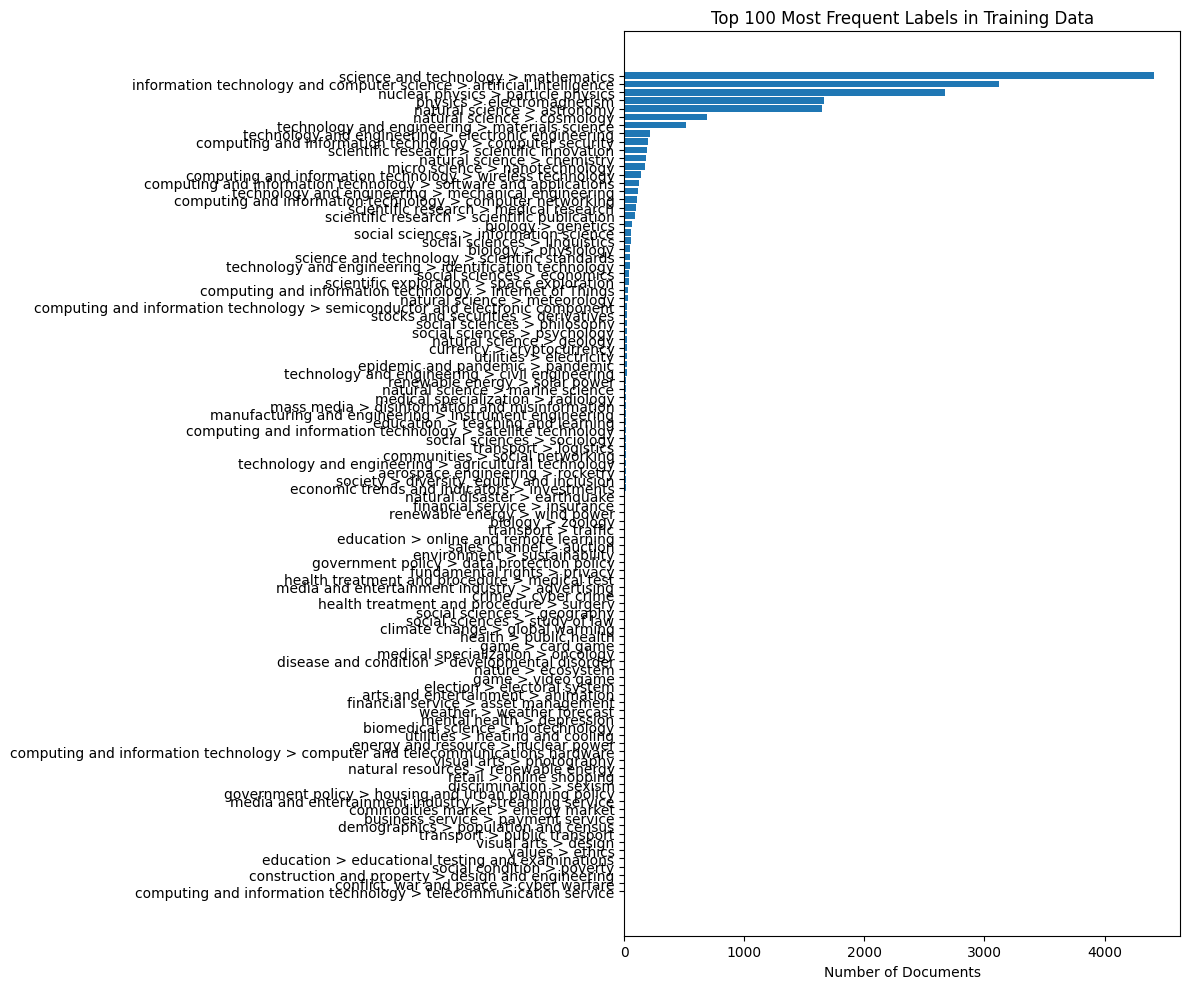

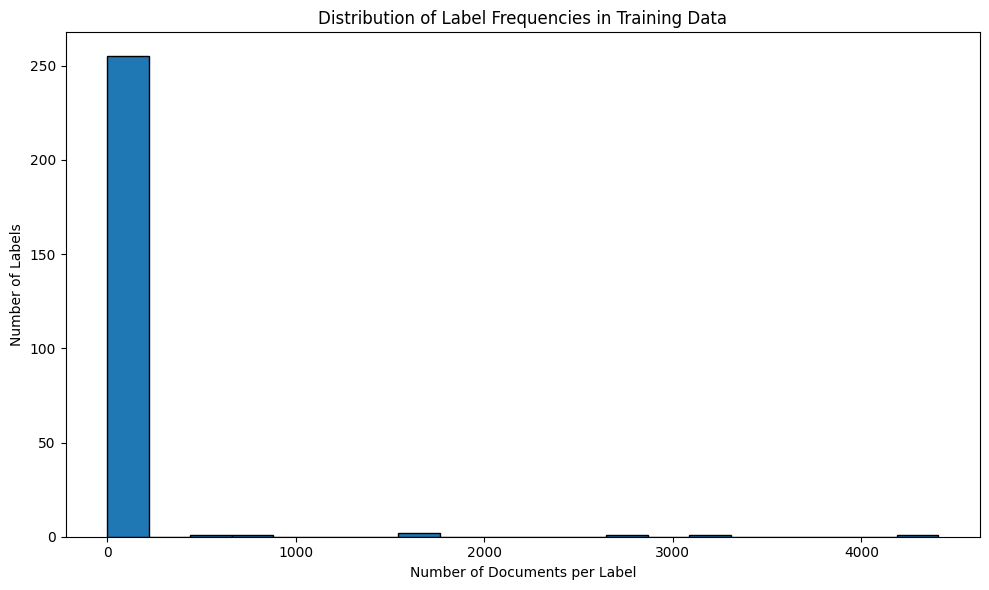

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(train_records, top_n=20):
    """
    Plots the distribution of labels in the training examples.

    Parameters:
    - train_records (list): List of dictionaries, each containing 'majority_id' and 'top_labels'.
    - top_n (int): Number of top labels to display in the bar plot (default: 20).
    """
    # Build a mapping from label codes to their formatted names using 'top_labels'
    code_to_label = {}
    for record in train_records:
        for code, label in record.get('top_labels', []):
            if code not in code_to_label:
                code_to_label[code] = label

    # Extract labels from 'majority_id', filtering out records where it is None
    labels = [record['majority_id'] for record in train_records if record.get('majority_id') is not None]

    # Count the frequency of each label
    label_counts = Counter(labels)

    # Print basic statistics
    print(f"Total labeled examples: {len(labels)}")
    print(f"Number of unique labels: {len(label_counts)}")

    # Helper function to shorten label names to the last two levels
    def shorten_label(label):
        # Remove definition in parentheses, if present
        label = label.split(' (')[0]
        # Split by ' > ' to get hierarchy levels
        parts = label.split(' > ')
        # Return the last two levels if available, otherwise the last level
        if len(parts) >= 2:
            return ' > '.join(parts[-2:])
        else:
            return parts[-1]

    # --- Bar Plot: Top N Most Frequent Labels ---
    # Get the top N labels and their counts
    top_labels = label_counts.most_common(top_n)
    # Shorten label names, falling back to code if not found in mapping
    top_label_names = [shorten_label(code_to_label.get(code, code)) for code, count in top_labels]
    top_counts = [count for code, count in top_labels]

    # Create the horizontal bar plot
    plt.figure(figsize=(12, 10))
    plt.barh(top_label_names, top_counts)
    plt.xlabel('Number of Documents')
    plt.title(f'Top {top_n} Most Frequent Labels in Training Data')
    plt.gca().invert_yaxis()  # Highest count at the top
    plt.tight_layout()
    plt.show()

    # --- Histogram: Distribution of Label Frequencies ---
    # Get all frequency counts
    counts = list(label_counts.values())

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(counts, bins=20, edgecolor='black')
    plt.xlabel('Number of Documents per Label')
    plt.ylabel('Number of Labels')
    plt.title('Distribution of Label Frequencies in Training Data')
    plt.tight_layout()
    plt.show()

from collections import Counter
import numpy as np

def print_label_statistics(train_records, threshold=20):
    """
    Prints statistics about the label distribution in the training examples.

    Parameters:
    - train_records (list): List of dictionaries, each containing 'majority_id'.
    """
    # Extract labels from 'majority_id', filtering out records where it is None
    labels = [record['majority_id'] for record in train_records if record.get('majority_id') is not None]

    # Count the frequency of each label
    label_counts = Counter(labels)

    # Calculate statistics
    counts = list(label_counts.values())
    num_classes = len(label_counts)
    if num_classes > 0:
        average_docs_per_class = np.mean(counts)
        max_docs = np.max(counts)
        min_docs = np.min(counts)
        classes_with_less_than_threshold = sum(1 for count in counts if count < threshold)
    else:
        average_docs_per_class = max_docs = min_docs = classes_with_less_than_threshold = 0

    # Print the requested statistics
    print(f"Average number of documents per class: {average_docs_per_class:.2f}")
    print(f"Maximum number of documents in a class: {max_docs}")
    print(f"Minimum number of documents in a class: {min_docs}")
    print(f"Number of classes with fewer than {threshold} documents: {classes_with_less_than_threshold}")


print_label_statistics(train_records, 20)

plot_label_distribution(train_records, top_n=100)

As we can see, the class distribution is highly imbalanced. We have 210 classes represented by fewer than 10 documents, which isn't good. Some class imbalance doesn't hurt, but here, we have only about 20-30 classes that were attached to the majority of documents.

In a business scenario, we would have to increase the presence of documents of minority classes in the training data. Otherwise, our model will not learn from just a few representatives of these classes.

To do that, we would:

1. Embed all unlabeled documents as well as all labeled documents labeled with minority classes,
2. Find the similar unlabeled documents to the labeled documents with minority labels according to cosine similarity
3. Use LMs to label these similar documents until a substantial number of examples get these minority labels (at least 10 per class, but the more the better with the goal of having a better balanced distribition of labels by class)

In this tutorial, we will make a different business decision which will save us model delivery time and money, but will require additional spendings in production.

**The decision is the following:** we will assign the "Other" label to all documents that were assigned an original label with less than 10 examples.

In a business scenario, this would mean that we would keep using the ensemble of LMs to label documents for which Other has been predicted by our classifier. Given that the number of such documents will be small, the cost of calling LMs will be greatly reduced compared to calling LMs for all documents:

In [ ]:
from collections import Counter
import numpy as np

def relabel_rare_classes(train_records, test_records, min_docs=10):
    """
    Processes training and testing records by keeping all examples with non-None labels and changing
    labels with fewer than min_docs occurrences in the training set to "Other." Prints statistics
    about the original training label distribution.

    Parameters:
    - train_records (list): List of dictionaries, each containing 'majority_id'.
    - test_records (list): List of dictionaries, each containing 'majority_id'.
    - min_docs (int): Minimum number of documents required per class to keep its original label (default: 10).

    Returns:
    - updated_train_records (list): Training records with rare labels changed to "Other".
    - updated_test_records (list): Testing records with labels not in common training labels changed to "Other".
    """
    # Step 1: Extract non-None labels from training records
    train_labels = [record['majority_id'] for record in train_records if record.get('majority_id') is not None]

    # Step 2: Count label frequencies
    label_counts = Counter(train_labels)

    # Step 3: Calculate and print statistics
    counts = list(label_counts.values())
    num_classes = len(label_counts)
    if num_classes > 0:
        average_docs_per_class = np.mean(counts)
        max_docs = np.max(counts)
        min_docs_stat = np.min(counts)
        classes_with_less_than_min = sum(1 for count in counts if count < min_docs)
    else:
        average_docs_per_class = max_docs = min_docs_stat = classes_with_less_than_min = 0

    print(f"Average number of documents per class: {average_docs_per_class:.2f}")
    print(f"Maximum number of documents in a class: {max_docs}")
    print(f"Minimum number of documents in a class: {min_docs_stat}")
    print(f"Number of classes with fewer than {min_docs} documents: {classes_with_less_than_min}")

    # Step 4: Identify common labels (those with at least min_docs)
    common_labels = {label for label, count in label_counts.items() if count >= min_docs}

    # Step 5: Helper function to decide the new label
    def update_label(record):
        return record['majority_id'] if record['majority_id'] in common_labels else "Other"

    # Step 6: Create updated training records
    updated_train_records = [
        {**record, 'majority_id': update_label(record)}
        for record in train_records if record.get('majority_id') is not None
    ]

    # Calculate and print the ratio of 'Other' labels in training set
    if updated_train_records:
        other_count = sum(1 for record in updated_train_records if record['majority_id'] == "Other")
        ratio = other_count / len(updated_train_records)
        print(f"Ratio of training documents labeled as 'Other': {ratio * 100:.2f}%")
    else:
        print("No labeled training documents.")

    # Step 7: Create updated testing records
    updated_test_records = [
        {**record, 'majority_id': update_label(record)}
        for record in test_records if record.get('majority_id') is not None
    ]

    return updated_train_records, updated_test_records

relabeled_train_records, relabeled_test_records = relabel_rare_classes(train_records, test_records, min_docs=20)

print(len(relabeled_train_records))

# Save the relabeled datasets to the new pickle files
from pathlib import Path
import pickle

drive_dir = Path("/content/drive/MyDrive/labeled_classifier_data")

drive_dir.mkdir(parents=True, exist_ok=True)

# Define new, descriptive file paths
relabeled_train_pkl = drive_dir / "relabeled_train_records.pkl"
relabeled_test_pkl = drive_dir / "relabeled_test_records.pkl"

with relabeled_train_pkl.open('wb') as f:
    pickle.dump(relabeled_train_records, f, protocol=pickle.HIGHEST_PROTOCOL)

with relabeled_test_pkl.open('wb') as f:
    pickle.dump(relabeled_test_records, f, protocol=pickle.HIGHEST_PROTOCOL)

# Print confirmation with the number of records saved and file locations
print(f"Saved {len(relabeled_train_records)} relabeled train records to {relabeled_train_pkl}")
print(f"Saved {len(relabeled_test_records)} relabeled test records to {relabeled_test_pkl}")

Average number of documents per class: 67.61
Maximum number of documents in a class: 4408
Minimum number of documents in a class: 1
Number of classes with fewer than 20 documents: 225
Ratio of training documents labeled as 'Other': 3.89%
17715
Saved 17715 relabeled train records to /content/drive/MyDrive/labeled_classifier_data/relabeled_train_records.pkl
Saved 435 relabeled test records to /content/drive/MyDrive/labeled_classifier_data/relabeled_test_records.pkl


## Training a Classifier

We are now ready to train. Let's first read the labeled documents from the pickle files and convert them into the format suitable for training with the `Hugging Face` API:

In [ ]:
!pip install datasets transformers evaluate
# Import necessary libraries
import pickle
from google.colab import drive
from pathlib import Path
from datasets import Dataset
from transformers import AutoTokenizer

drive.mount('/content/drive')

# Define the directory and file paths
drive_dir = Path("/content/drive/MyDrive/labeled_classifier_data")
train_pkl = drive_dir / "relabeled_train_records.pkl"
test_pkl = drive_dir / "relabeled_test_records.pkl"

# Load the training and test records from pickle files
with train_pkl.open('rb') as f:
    train_records = pickle.load(f)

with test_pkl.open('rb') as f:
    test_records = pickle.load(f)

# Get unique labels from the training records and create a mapping to integer IDs
train_labels = set(record['majority_id'] for record in train_records)
print("The number of unique labels in the training data:", len(train_labels))
label_to_id = {label: idx for idx, label in enumerate(sorted(train_labels))}

# Filter test records to only include labels present in the training set
test_records = [record for record in test_records if record['majority_id'] in train_labels]

# Create lists of texts and label IDs for training and test sets
train_texts = [f"Title: {record['title']}\nAbstract: {record['abstract']}" for record in train_records]
train_label_ids = [label_to_id[record['majority_id']] for record in train_records]

test_texts = [f"Title: {record['title']}\nAbstract: {record['abstract']}" for record in test_records]
test_label_ids = [label_to_id[record['majority_id']] for record in test_records]

# Create Hugging Face Dataset objects
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_label_ids})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_label_ids})

# Load the RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Define the tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

# Apply tokenization to the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# At this point, train_dataset and test_dataset are ready for fine-tuning
print("Training dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00
Mounted at /content/drive
The number of unique labels in the training data: 38


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/17715 [00:00<?, ? examples/s]

Map:   0%|          | 0/435 [00:00<?, ? examples/s]

Training dataset size: 17715
Test dataset size: 435


Now we have the data in the format expected by the Hugging Face API, so we can start training. We will finetune RoBERTa as our **baseline**:

In [ ]:
import os
import wandb

# Set the WandB project name via environment variable
os.environ['WANDB_PROJECT'] = 'document-classifier'

# Log in to WandB using your API key
wandb.login(key='PUT YOUR KEY HERE')  # Replace with your actual WandB API key

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: burkov to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Import necessary libraries
import os
import evaluate
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Check if GPU is available and print the device being used
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Define the model name
model_name = 'roberta-base'

# Load the RoBERTa model for sequence classification
# Replace 'label_to_id' with your actual label mapping
num_labels = len(label_to_id)  # Number of classes in your dataset
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

# Load the accuracy metric from the evaluate library
accuracy_metric = evaluate.load("accuracy")

# Define the compute_metrics function to calculate accuracy
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=p.label_ids)

# Set up training arguments with WandB logging enabled and dynamic run name
training_args = TrainingArguments(
    output_dir='./results',                # Directory to save model outputs
    num_train_epochs=20,                    # Number of training epochs
    per_device_train_batch_size=32,        # Batch size for training
    per_device_eval_batch_size=32,         # Batch size for evaluation
    warmup_steps=250,                      # Number of warmup steps
    logging_steps=10,                      # Log every 10 steps
    eval_strategy='epoch',                 # Evaluate at the end of each epoch
    report_to=['wandb'],                   # Log metrics to WandB
    run_name=f'{model_name}-finetune'      # Dynamic run name including model name
)

# Create the Trainer object with compute_metrics for accuracy logging
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,           # Replace with your training dataset
    eval_dataset=test_dataset,             # Replace with your evaluation dataset
    compute_metrics=compute_metrics        # Function to compute accuracy
)

# Fine-tune the model
trainer.train()

# Evaluate the model and log results to WandB
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

wandb.finish()

Using device: cuda


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.907700,0.890951,0.749425
2,0.665100,0.839363,0.763218
3,0.560100,0.850221,0.760920
4,0.357100,0.778706,0.797701
5,0.245000,0.967360,0.795402
6,0.202100,1.003320,0.786207
7,0.146200,1.155853,0.772414
8,0.086500,1.368565,0.783908
9,0.107500,1.351398,0.786207
10,0.075700,1.422771,0.783908


Evaluation results: {'eval_loss': 1.8889778852462769, 'eval_accuracy': 0.7931034482758621, 'eval_runtime': 2.7432, 'eval_samples_per_second': 158.575, 'eval_steps_per_second': 5.104, 'epoch': 20.0}


eval/accuracy,▁▃▂▇▇▆▄▅▆▅▄▄▆▅██▇▆▆▇▇
eval/loss,▂▁▁▁▂▂▃▄▄▅▆▆▅▇▆▇▇█▇▇▇
eval/runtime,▄▁▂▂▁▂▁▂▂▂▂▁▂▁▂▁▂▂▂█▂
eval/samples_per_second,▅█▇▇█▇█▇▇▇▇█▇█▇█▇▇▇▁▇
eval/steps_per_second,▅█▇▇█▇█▇▇▇▇█▇█▇█▇▇▇▁▇
train/epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
train/grad_norm,▄▃▂▃▃▃▃▅▂▇▁▅▂█▅▂▄▅▁▁▄▁▆▁█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▆██▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁
train/loss,█▆▆▅▄▃▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.7931


So, our baseline is 80.46% with RoBERTa-base with all default hyperparatemers except for a short warmup.

The accuracy number on its own doesn't tell us whether the model is good in practice or not. First of all, our data has a serious class imbalance, which makes the accuracy as a metric less informative. Furthermore, in a multiclass classification, when the classes are very granular (which is our case with more tham 1200 options), two or more classes can often be appropriate for the same input, especially in predicting a topic of a document: one document can contain a mixture of several topics.

For us, 80.46% accuracy is a baseline which we will use as the minimum performance level when considering more complex solutions. More specifically, we will compare it to the accuracy of larger models we will finetune on the same dataset.

Let's finetune a larger model: Qwen/Qwen2.5-1.5B-Instruct. It's an instruct-finetued language model with 1.5B parameters.

This model has two advantages over RoBERTa:

- It has a much longer context of 32k tokens (compared to 512 tokens in RoBERTa), which allows us to put more information in the input
- It understand instructions, so we can use the prompt we used above to get the labels from off-the-shelf LLMs, which will simplify for the model the task of selecting the right model.

Let's prepare the training data for Qwen:

In [ ]:
# Install necessary libraries
!pip install datasets transformers evaluate peft

# Import necessary libraries
import os
import wandb
import torch
import pickle
import numpy as np
import evaluate
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from pathlib import Path
from google.colab import drive
from peft import LoraConfig, get_peft_model

def print_trainable_ratio(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    ratio = trainable_params / total_params
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Ratio of trainable parameters: {ratio * 100:.2f}%")

# Mount Google Drive to access dataset files
drive.mount('/content/drive')

# Define the directory and file paths
drive_dir = Path("/content/drive/MyDrive/labeled_classifier_data")
train_pkl = drive_dir / "relabeled_train_records.pkl"
test_pkl = drive_dir / "relabeled_test_records.pkl"

# Load the training and test records from pickle files
with train_pkl.open('rb') as f:
    train_records = pickle.load(f)

with test_pkl.open('rb') as f:
    test_records = pickle.load(f)

# Identify common labels from train_records (excluding "Other")
common_labels = set(record['majority_id'] for record in train_records if record['majority_id'] != "Other")

# Create label mapping from all possible majority_id values (including "Other")
all_labels = set(record['majority_id'] for record in train_records)
label_to_id = {label: idx for idx, label in enumerate(sorted(all_labels))}

# Create reverse mapping for label IDs to label names
id_to_label = {id: label for label, id in label_to_id.items()}

# Function to generate category list for prompts
def generate_category_list(top_labels, common_labels):
    filtered_labels = [(code, label) for code, label in top_labels if code in common_labels]
    category_list = "\n".join(f"ID: {code}, PATH: {label}" for code, label in filtered_labels)
    category_list += "\nID: Other, PATH: Other (Documents that do not fit into any specific category)"
    return category_list

# Function to create prompts
def create_prompt(record, common_labels):
    title = record['title']
    abstract = record['abstract']
    category_list = generate_category_list(record['top_labels'], common_labels)
    prompt = f"""
You are a document classification assistant. Your task is to classify the given document into the most appropriate category from the provided list of categories. The document consists of a title and an abstract. The categories are provided with their IDs and full hierarchical paths and definitions in the following format:

ID: [ID], PATH: Level 1 > Level 2 > ... > Level 6 (definition)

For example:

ID: medtop:20000842, PATH: sport > competition discipline > track and field > relay run (A team of athletes run a relay over identical distances)

Here is the document to classify:

Title: {title}

Abstract: {abstract}

Here are the possible categories:

{category_list}

Select the most appropriate category for this document from the list above. Provide only the ID of the selected category. If none of the specific categories are appropriate, choose 'Other'.
"""
    return prompt.strip()

# Create prompts and label IDs for training and test sets
train_prompts = [create_prompt(record, common_labels) for record in train_records]
train_label_ids = [label_to_id[record['majority_id']] for record in train_records]

test_prompts = [create_prompt(record, common_labels) for record in test_records]
test_label_ids = [label_to_id[record['majority_id']] for record in test_records]

print("First training example:")
print("Input text:")
print(train_prompts[0])
print("\nOutput label:", id_to_label[train_label_ids[0]])

# Create Hugging Face Dataset objects
train_dataset = Dataset.from_dict({'text': train_prompts, 'label': train_label_ids})
test_dataset = Dataset.from_dict({'text': test_prompts, 'label': test_label_ids})

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

Now, let's finetune it using LoRA to save time and GPU expenses:

> LoRA is a technique that consists of injecting several new learnable parameters into the LM and keep the original model parameters "frozen." This allows speeding up the training and using larger batches because when we train fewer parameters, the gradients of these parameters also take less GPU memory.

In [ ]:
# Define the model name
model_name = 'Qwen/Qwen2.5-1.5B-Instruct'

# Load the Qwen tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Define the tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=768)

# Apply tokenization to the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Print dataset sizes for verification
print("Training dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# Load Qwen model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_to_id),
    pad_token_id=tokenizer.eos_token_id
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)
model = get_peft_model(model, lora_config)
print_trainable_ratio(model)
model.to(device)  # Ensure the model remains on the correct device after LoRA application

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    warmup_steps=250,
    logging_steps=10,
    learning_rate=2e-5,
    weight_decay=0.1,
    eval_strategy='epoch',
    report_to=['wandb'],
    run_name=f'{model_name}-finetune-lora'
)

# Load accuracy metric for evaluation
accuracy_metric = evaluate.load("accuracy")

# Define compute_metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=p.label_ids)

label_names = [id_to_label[i] for i in range(len(label_to_id))]
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Optional: Finish WandB run
wandb.finish()

# Optional: Exit the script cleanly
import os
os._exit(0)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Map:   0%|          | 0/17715 [00:00<?, ? examples/s]

Map:   0%|          | 0/435 [00:00<?, ? examples/s]

Training dataset size: 17715
Test dataset size: 435


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-1.5B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 1,548,189,184
Trainable parameters: 4,416,512
Ratio of trainable parameters: 0.29%


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.849200,0.811016,0.804598
2,0.815700,0.622800,0.834483
3,0.480200,0.613502,0.825287
4,0.266200,0.666795,0.834483
5,0.298000,0.624681,0.845977


Epoch,Training Loss,Validation Loss,Accuracy
1,0.849200,0.811016,0.804598
2,0.815700,0.622800,0.834483
3,0.480200,0.613502,0.825287
4,0.266200,0.666795,0.834483
5,0.298000,0.624681,0.845977
6,0.230800,0.609724,0.866667


We only managed to train for 6 epochs, because Colab has a limit on the session length, unless we opt for Colab Pro, which is quite expensive.

As we can see, the highest accuracy with `Qwen/Qwen2.5-1.5B-Instruct` is 86.67% which is 6.21 percentage points higher than RoBERTa's 80.46%. It's a great increase given that all we did is to finetune a larger model. We didn't play with the label distribution in the training set trying to make it more flat, we didn't do any hyperparameter tuning, and we didn't labeled more data.

Let's train a 7B model and see if it allows increasing accuracy. With Colab, training models larger than 2B parameters is practically challenging. The process will be slow and take several days. So, we need Colab Pro and a lot of time. Instead, we will use [SwarmOne](https://swarmone.ai/) who generously shared credits with me to finish this tutorial.

Let's train a 7B model. With Colab, training models larger than 2B parameters is practically challenging. The process will be slow and take several days. So, we need Colab Pro and a lot of time. Instead, we will use [SwarmOne](https://swarmone.ai/) who generously shared credits with me to finish this tutorial.

> SwarmOne let's you train models of different size without thinking about GPUs. You simply choose the model size you want to train and the system finds the best hardware and the best way to distribute the training for this model size and the shape of the training data.

For `Qwen/Qwen2.5-7B-Instruct`, and the following hyperparameters:

```
    lora_r = 64
    lora_alpha = 128
    max_length = 5120
    batch_size = 6
```

we have the accuracy of 90.14%:
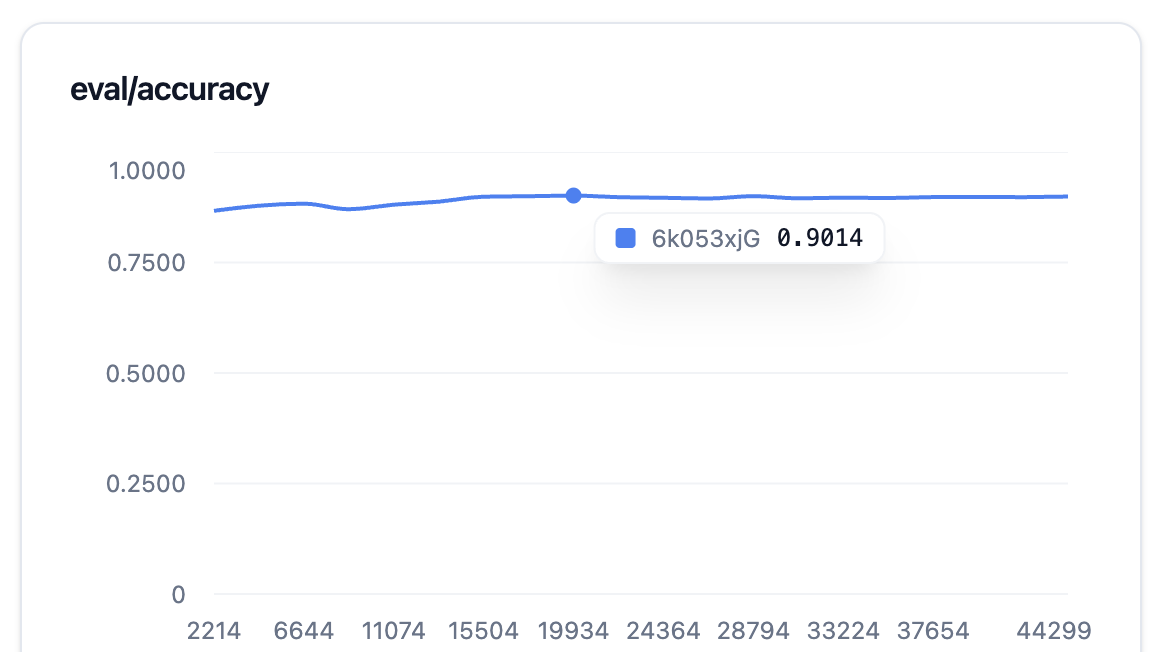

For `Qwen/Qwen2.5-14B-Instruct` with the following values of hyperparamaters:

```
    lora_r = 64
    lora_alpha = 128
    max_length = 5120
    batch_size = 6
```

we have the accuracy of 90.60%:

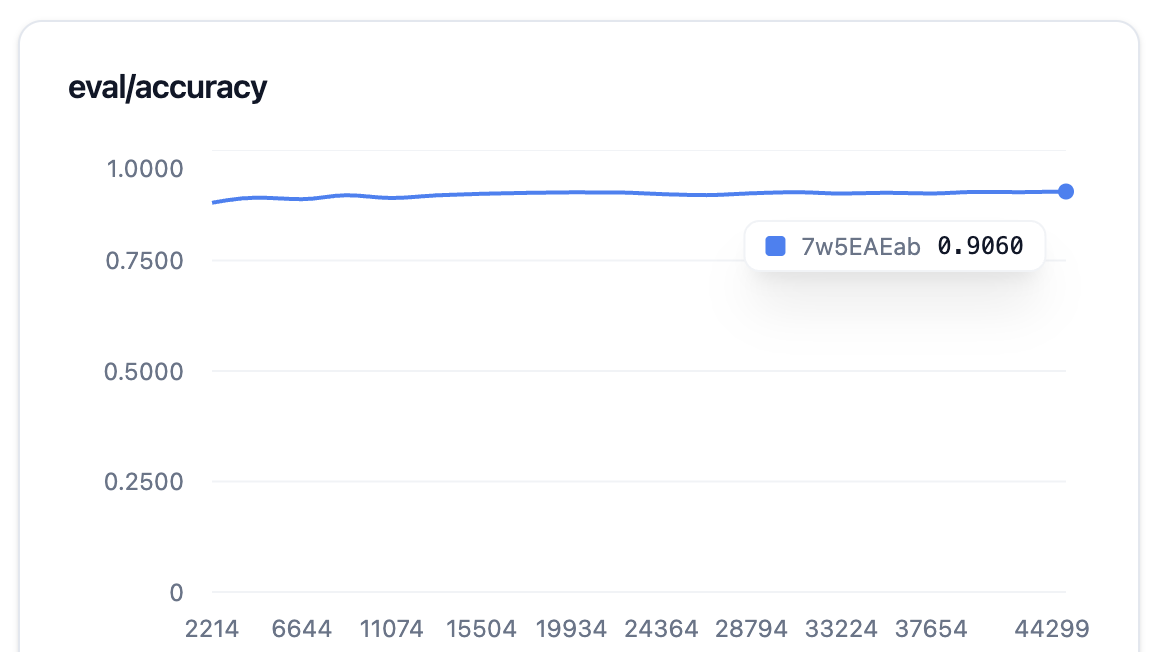

Given that we don't see a substantial increase in accuracy by doubling the size of the model, we stop.

In a business context, for each size of the model, depending on the available budget, we would run several experiments by changing such hyperparameters as model size, batch size, context size, LoRA's `r` and `alpha`, try different initialization algorithms for LoRA parameters, and try full finetune instead of LoRA. This would most likely result in an experiment yielding a model with a better accuracy.

Overall, for a multiclass classifier with 38 labels (37 labels from the taxonomy plus `Other`), any result above 90% is good. Most of the "errors" are classes that would equally fit.

But if we had a budget for more experiments, for a longer context than 5000 tokens (to include more labels in the text format into the prompt), for labeling not 20,000 but 200,000 documents, and for building a better balanced dataset, the actual production accuracy might be much higher.